# Análisis de datos postura: *Downdog*

### Calculo de los angulos medios de la postura para determinar el angulo ideal de la postura

## Posture data analysis: *Downdog*

#### Calculation of mean stance angles to determine the ideal stance angle

In [1]:
# Import libraries
import cv2
import math
import numpy as np
import pandas as pd
import mediapipe as mp
from matplotlib import pyplot as plt

### Definición de funciones de cálculo de ángulos

#### Definition of angle calculation functions

In [2]:
# Function for calculating the angles
def calculate_angle_coord(p_cood_list):
    """
    Calculate the angle formed by three coordinates in a 2D plane.

    Parameters:
        p_cood_list (list): A list containing three 2D coordinate points as numpy arrays.

    Returns:
        float: The angle in degrees between the lines connecting the first and second points
               and the second and third points. The angle is always in the range [0, 180].
    
    first_point = p_cood_list[0][*]
    mid_point = p_cood_list[1][*]
    last_point = p_cood_list[2][*]
    """
    radians = math.atan2(p_cood_list[2][1]-p_cood_list[1][1], p_cood_list[2][0]-p_cood_list[1][0]) - \
        math.atan2(p_cood_list[0][1]-p_cood_list[1][1], p_cood_list[0][0]-p_cood_list[1][0])
    angle = abs(radians*180.0/math.pi)

    if angle > 180.0:
        angle = 360-angle

    return angle

In [3]:
# Function to calculate the angles of the dataset

def angles_df(points, df, visibility):

    ang_points_coord= [[j+str(i)  for j in ['x', 'y', 'v']] for i in points]
    angle = []

    for j in range(df.shape[0]):
        l = []
        for i in ang_points_coord:
            if df[i[2]][j] > visibility:
                corr = (df[i[0]].iloc[j], df[i[1]].iloc[j])
                l.append(corr)
        if len(l) == 3:
            angle.append(int(calculate_angle_coord(l)))
    
    return angle

### Puntos para calcular el angulo

In [4]:
# Points for calculating the value angle of the middle of each tuple
#'downdog'
p_list = [(12, 24, 26), 
        (24, 26, 28), 
        (24, 12, 14),
        (12, 14, 16), 
        (11, 23, 25), 
        (23, 25, 27),
        (23, 11, 13), 
        (11, 13, 15)] 

![Alt text](..\interface\pages\Data\images_display\Landmarks.png)

### Representación de los puntos en imagen de la postura con su medición del ángulo

#### Representation of points in posture image with their angle measurement

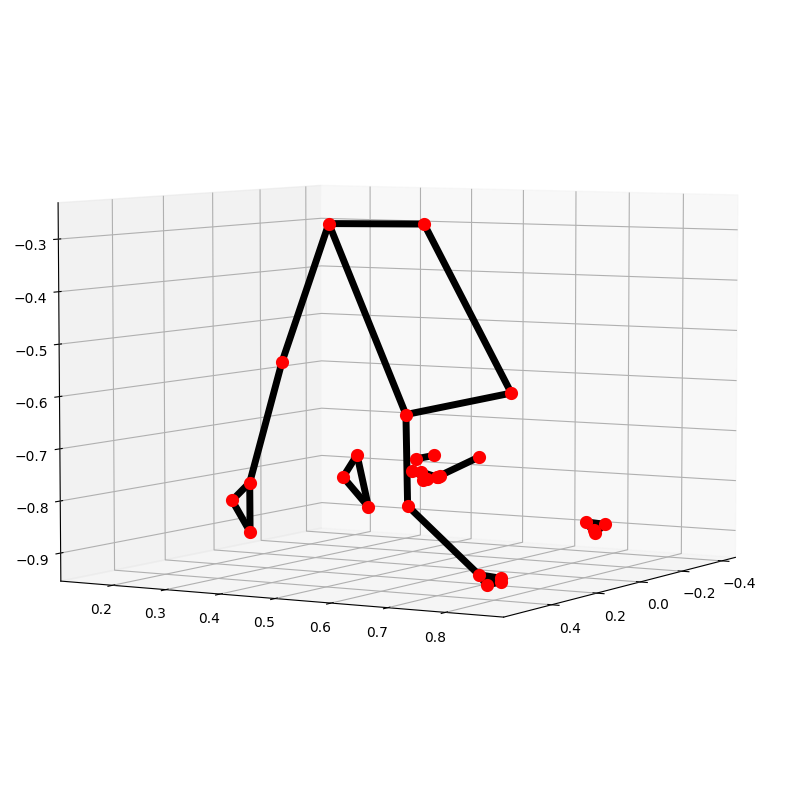

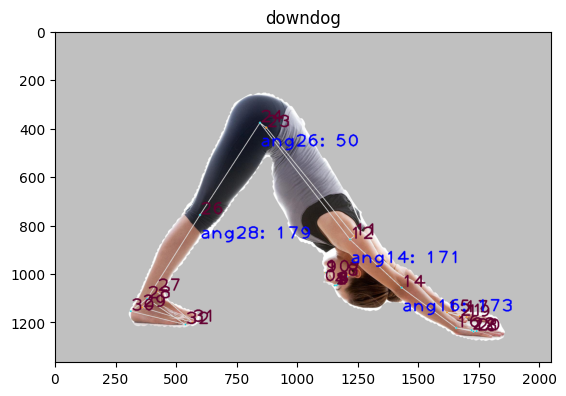

In [5]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# For static images:

path = '..\DATASET\TRAIN\downdog\\00003.jpg'
#image = cv2.imread(path)

IMAGE_FILES = [path]
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode=True,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
  
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue

    annotated_image = image.copy()
    # Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    annotated_image = np.where(condition, annotated_image, bg_image)

    # Draw pose landmarks on the image.
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        
    landmrk_value = [l.value for l in mp_pose.PoseLandmark]

    text_size = int(round(np.linalg.norm(annotated_image.shape)*0.002,0))

    poses = results.pose_landmarks.landmark
    pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in poses]).flatten())

    for i in landmrk_value:
      if  results.pose_landmarks.landmark[i].visibility > 0.5 : 
        cv2.putText(annotated_image, str(i), (int((results.pose_landmarks.landmark[i].x)*annotated_image.shape[1]) , 
                                              int((results.pose_landmarks.landmark[i].y)*annotated_image.shape[0])),
                    cv2.FONT_HERSHEY_PLAIN, text_size, (50, 0, 100), text_size)
           
    
    for i in range(len(p_list)):
        p_cood_list = []
        midle_point = p_list[i][1]
        for p in p_list[i]:
            if results.pose_landmarks.landmark[p].visibility > 0.5:
                p_corrd = (results.pose_landmarks.landmark[p].x, results.pose_landmarks.landmark[p].y)
                p_cood_list.append(p_corrd)
            else:
                break

        try:
            angle = int(calculate_angle_coord(p_cood_list))
            cv2.putText(annotated_image, str(f'ang{p_list[i][2]}: {angle}'), (int((results.pose_landmarks.landmark[midle_point].x)*annotated_image.shape[1]) , 
                          100+int((results.pose_landmarks.landmark[midle_point].y)*annotated_image.shape[0])),
                          cv2.FONT_HERSHEY_PLAIN, text_size, (255,0,0), text_size)

        except:
            pass
      
   
    
    cv2.imwrite('images/annotated_image' + str(idx) + '.png', annotated_image)
    # Plot pose world landmarks.

mp_drawing.plot_landmarks(results.pose_landmarks, mp_pose.POSE_CONNECTIONS, elevation = 5, azimuth= 30)

image_pose = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_pose)
plt.title('downdog')
plt.show()

## Carga del dataset

### Load dataset

In [6]:
df_downdog_train = pd.read_csv('../coord_dataset_csv/df_downdog_train.csv')
df_downdog_test = pd.read_csv('../coord_dataset_csv/df_downdog_test.csv')
df_downdog = pd.concat([df_downdog_train, df_downdog_test],
                         ignore_index=True)
df_downdog

,class,path,x0,y0,z0,v0,x1,y1,z1,v1,...,z30,v30,x31,y31,z31,v31,x32,y32,z32,v32
0,downdog,DATASET/TRAIN/downdog\00000.jpg,0.511189,0.727550,-0.076373,0.999087,0.494254,0.750801,-0.115903,0.999525,...,0.349741,0.572870,0.789083,0.920681,-0.254881,0.981300,0.775926,0.902560,0.247644,0.584526
1,downdog,DATASET/TRAIN/downdog\00001.jpg,0.568022,0.786379,-0.044425,0.999655,0.581655,0.794644,-0.024105,0.999690,...,-0.142834,0.996496,0.248387,0.902885,0.072101,0.638526,0.238052,0.910098,-0.274867,0.992569
2,downdog,DATASET/TRAIN/downdog\00002.jpg,0.608902,0.736586,-0.031492,0.999770,0.629058,0.740810,-0.005169,0.999771,...,-0.146727,0.996390,0.212486,0.909015,0.215780,0.676139,0.201758,0.923530,-0.320097,0.993469
3,downdog,DATASET/TRAIN/downdog\00003.jpg,0.541984,0.758109,-0.096469,0.999904,0.561617,0.768991,-0.074017,0.999896,...,-0.031129,0.997919,0.276310,0.879952,0.286139,0.832718,0.262517,0.886805,-0.191682,0.996327
4,downdog,DATASET/TRAIN/downdog\00004.jpg,0.360903,0.700388,-0.033786,0.997857,0.340383,0.711678,-0.076438,0.998727,...,0.364820,0.468797,0.745153,0.924358,-0.274635,0.975121,0.724463,0.912739,0.272612,0.477174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,downdog,DATASET/TEST/downdog\00280.jpg,0.522380,0.699822,-0.102985,0.999964,0.539745,0.713941,-0.077687,0.999960,...,-0.077838,0.998538,0.204845,0.839701,0.203039,0.879615,0.193243,0.851316,-0.238293,0.997501
281,downdog,DATASET/TEST/downdog\00281.jpg,0.526245,0.656758,-0.047714,0.999637,0.537344,0.671504,-0.033911,0.999613,...,0.040548,0.980108,0.342292,0.833532,0.217225,0.668851,0.329257,0.851598,-0.054575,0.974423
282,downdog,DATASET/TEST/downdog\00282.jpg,0.568252,0.718830,-0.029231,0.999977,0.589984,0.729624,-0.012618,0.999975,...,0.015956,0.999060,0.241047,0.799065,0.257730,0.921940,0.207212,0.838860,-0.127026,0.998522
283,downdog,DATASET/TEST/downdog\00283.jpg,0.459578,0.722023,0.040903,0.999918,0.443140,0.736588,0.015767,0.999942,...,0.182449,0.386657,0.734798,0.899292,-0.202779,0.968718,0.720417,0.876663,0.087585,0.495930


In [7]:
# Minimum visibility
visibility = 0.8

### Lado derecho del cuerpo

#### body right side

In [8]:
# Points on the rigth side
ang12_points  = [24,12,14]
ang14_points  = [12,14,16]
ang24_points  = [12,24,26]
ang26_points  = [24,26,28]

In [9]:
ang12 = pd.DataFrame({'ang12':angles_df(ang12_points, df_downdog, visibility)})
ang12.describe()

,ang12
count,122.000000
mean,168.860656
std,7.479245
min,142.000000
25%,165.000000
50%,171.000000
75%,174.000000
max,179.000000


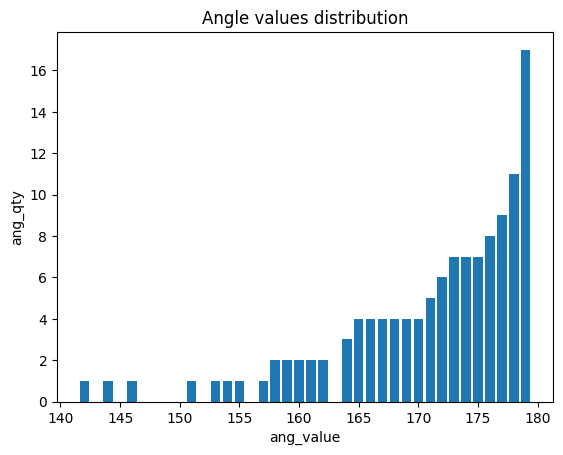

In [11]:
plt.bar(ang12['ang12'].sort_values().unique(), ang12['ang12'].value_counts().sort_values()), 
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [13]:
ang14 = pd.DataFrame({'ang14':angles_df(ang14_points, df_downdog, visibility)})
ang14.describe()

,ang14
count,121.000000
mean,165.066116
std,9.384149
min,101.000000
25%,161.000000
50%,166.000000
75%,171.000000
max,179.000000


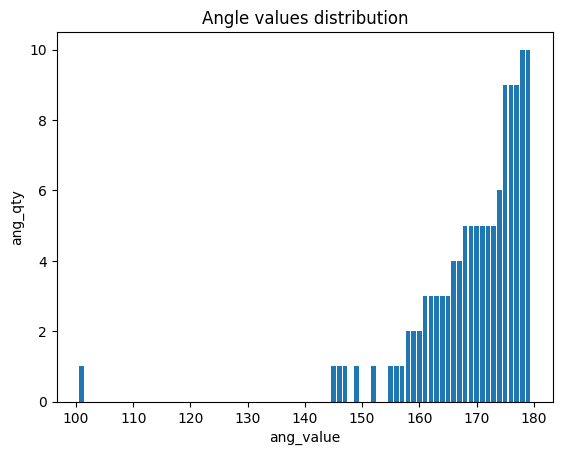

In [14]:
plt.bar(ang14['ang14'].sort_values().unique(), ang14['ang14'].value_counts().sort_values()), 
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [15]:
ang24 = pd.DataFrame({'ang24':angles_df(ang24_points, df_downdog, visibility)})
ang24.describe()

,ang24
count,120.000000
mean,56.300000
std,13.067118
min,30.000000
25%,49.750000
50%,54.000000
75%,62.250000
max,107.000000


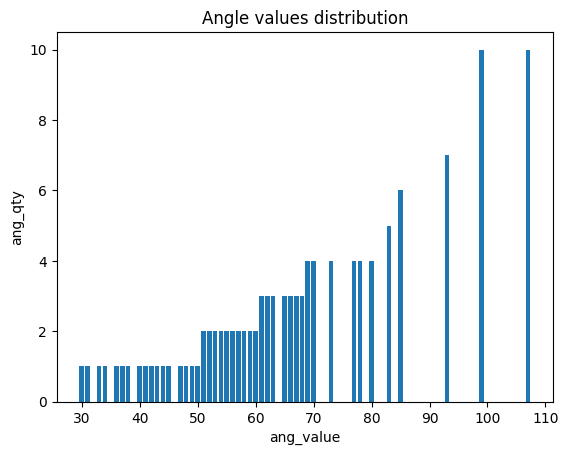

In [16]:
plt.bar(ang24['ang24'].sort_values().unique(), ang24['ang24'].value_counts().sort_values()), 
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [18]:
ang26 = pd.DataFrame({'ang26':angles_df(ang26_points, df_downdog, visibility)})
ang26.describe()

,ang26
count,119.000000
mean,174.403361
std,6.983418
min,133.000000
25%,174.000000
50%,176.000000
75%,178.000000
max,179.000000


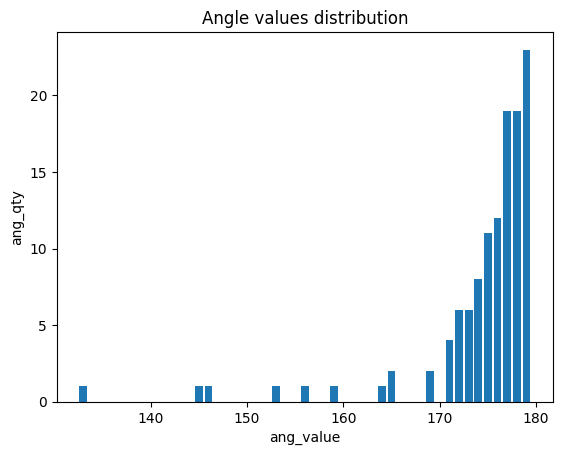

In [19]:
plt.bar(ang26['ang26'].sort_values().unique(), ang26['ang26'].value_counts().sort_values()), 
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

### Lado izquierdo del cuerpo

#### body left side

In [21]:
# Points on the left side
ang11_points  = [23,11,13]
ang13_points  = [11,13,15]
ang23_points  = [11,23,25]
ang25_points  = [23,25,27]

In [22]:
ang11 = pd.DataFrame({'ang11':angles_df(ang11_points, df_downdog, visibility)})
ang11.describe()

,ang11
count,167.000000
mean,169.431138
std,9.359281
min,133.000000
25%,164.000000
50%,172.000000
75%,176.500000
max,179.000000


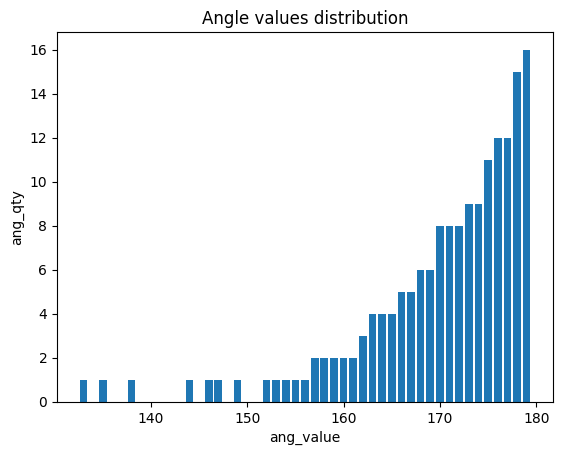

In [23]:
plt.bar(ang11['ang11'].sort_values().unique(), ang11['ang11'].value_counts().sort_values()), 
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [24]:
ang13 = pd.DataFrame({'ang13':angles_df(ang13_points, df_downdog, visibility)})
ang13.describe()

,ang13
count,165.000000
mean,167.115152
std,6.680337
min,118.000000
25%,164.000000
50%,168.000000
75%,171.000000
max,179.000000


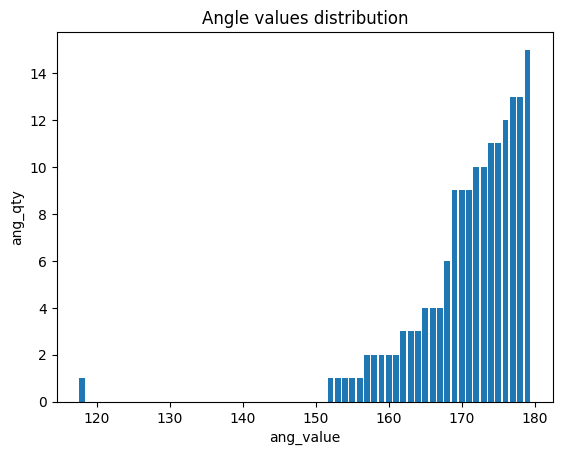

In [25]:
plt.bar(ang13['ang13'].sort_values().unique(), ang13['ang13'].value_counts().sort_values()), 
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [26]:
ang23 = pd.DataFrame({'ang23':angles_df(ang23_points, df_downdog, visibility)})
ang23.describe()

,ang23
count,164.000000
mean,57.792683
std,11.889819
min,33.000000
25%,49.000000
50%,57.000000
75%,63.000000
max,94.000000


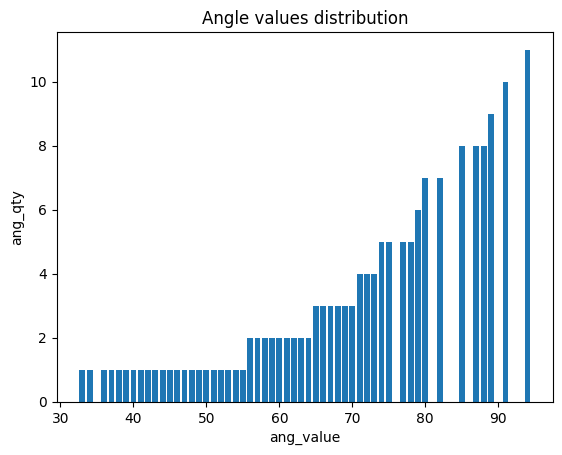

In [27]:
plt.bar(ang23['ang23'].sort_values().unique(), ang23['ang23'].value_counts().sort_values()), 
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [29]:
ang25 = pd.DataFrame({'ang25':angles_df(ang25_points, df_downdog, visibility)})
ang25.describe()

,ang25
count,163.000000
mean,174.730061
std,7.048388
min,134.000000
25%,174.000000
50%,177.000000
75%,178.000000
max,179.000000


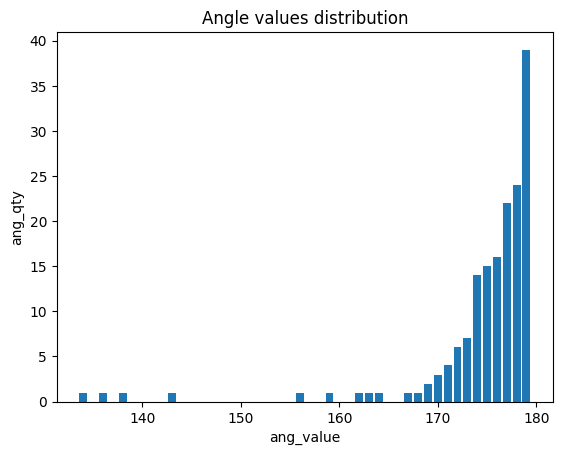

In [30]:
plt.bar(ang25['ang25'].sort_values().unique(), ang25['ang25'].value_counts().sort_values()), 
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

## Valores medios de los ángulos para cada punto

### Average values of the angles for each point

In [93]:
results = pd.DataFrame({'ang: 11-12' : (int(ang11.mean().item()), int(ang12.mean().item())), 
                        'ang: 13-14' : (int(ang13.mean().item()), int(ang14.mean().item())), 
                        'ang: 23-24' : (int(ang23.mean().item()), int(ang24.mean().item())),
                        'ang: 25-26' : (int(ang25.mean().item()), int(ang26.mean().item()))},
                        index=['left', 'right'])
results

,ang: 11-12,ang: 13-14,ang: 23-24,ang: 25-26
left,169,167,57,174
right,168,165,56,174
